<a href="https://colab.research.google.com/github/guimarczewski/colab/blob/master/Probabilidade_de_Contato_Bradesco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probabilidade de Contato

Script para definir, com base no histórico de tabulações, a probabilidade de contato de um determinado cliente. Além dos pontos de localização, é informado se o cliente já teve promessa e cpc nos últimos 30 dias e nos últimos 90 dias, além da última ocorrência e sua data correspondente.

## Importando bibliotecas e verificando mapeamento no Google Drive

In [ ]:
#importando bibliotecas necessárias
import os
import pandas as pd
import glob
from datetime import datetime, timezone, timedelta

#conectando ao Google Drive
from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#verificando diretório atual
os.getcwd()

'/content'

In [ ]:
#alterando para diretório com arquivos de histórico
os.chdir('/content/gdrive/Shareddrives/Bradesco/Estudos/ProbabilidadeLoc/Historico')

In [ ]:
#verificando se alterou diretório
os.getcwd()

'/content/gdrive/Shareddrives/Bradesco/Probabilidade de Contato - Bradesco/Historico'

## ETL e Output

**ARQUIVOS**

O arquivo de históricos é obtido através do agrupamento de todos os arquivos CSV que estão no diretório '/content/gdrive/Shareddrives/Bradesco/Historico'. São os arquivos que possuem o histórico de acionamentos diários das carteiras do Bradesco.


G:\Drives compartilhados\Bradesco\De_para:


*   descpts.csv: pontuação das classificações de ocorrências.
*   diasAcion.csv: pesos para as datas de acionamento. Quanto maior o atraso, menor o peso.
*   dOcorrencias.csv: de_para ocorrências x classificações.

*   estoque.csv: Contrato/Alçada/Faixa de Atraso.

In [ ]:
#agrupando os arquivos csv do diretório atual e transformando os campos 'contrato' e 'CPFCNPJ' em string
extensao = 'csv'

arquivos_csv = [i for i in glob.glob('*.{}'.format(extensao))]
concatenado = pd.concat([pd.read_csv(f, sep=';', encoding='latin-1', dtype={'Contrato': str,'CPFCNPJ':str}) for f in arquivos_csv ])

In [ ]:
#ajustando o nome das colunas que estavam invertidos
df = concatenado.rename(columns={'Hora': 'Data','Data': 'Hora'})

In [ ]:
#retirando os acionamentos do sistema
df_new = df['Login']!='sistema'
filtered_df = df[df_new]

In [ ]:
#criando nova coluna data/hora
filtered_df["data/hora"] = (filtered_df["Data"].astype(str)) + " " + (filtered_df["Hora"].astype(str))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#ajustando o formato da coluna data e da coluna data/hora
filtered_df['data/hora'] = pd.to_datetime(filtered_df['data/hora'], format="%Y-%m-%d %H:%M")
filtered_df['Data'] = pd.to_datetime(filtered_df['Data'], format="%Y-%m-%d")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#removendo colunas que não serão usadas
df_work = filtered_df.drop(filtered_df.columns[[0, 3, 4, 5, 6, 8, 9, 11]], axis=1)

In [ ]:
#filtrando um determinado CPF
#df_excluir = df_work[df_work.CPFCNPJ.eq(5935160609)]
#df_excluir.head(15)

In [ ]:
#carregando df de_para
df_depara = pd.read_csv('/content/gdrive/Shareddrives/Bradesco/Estudos/ProbabilidadeLoc/Planilhas/dOcorrencias.csv', 
                        sep = ';', encoding = 'latin-1')

In [ ]:
#ajustando o nome das colunas que estavam invertidos
df_depara = df_depara.rename(columns={'Tabulacao': 'Ocorrencia'})

Join no python.

https://estatsite.com.br/2019/04/30/join-merge-no-python-pandas/

In [ ]:
#join dos dataframes
df_join = pd.merge(df_work, df_depara, on="Ocorrencia", how="left")

In [ ]:
#filtrando somente valores nulos e removendo duplicatas
filtered_df = df_join[df_join['classificacao'].isnull()]
df_null = filtered_df.drop_duplicates(subset=['Ocorrencia'])

In [ ]:
#removendo colunas que não serão usadas
df_null = df_null.drop(df_null.columns[[0, 1, 2, 4]], axis=1)

Exibir dados diretamente no formato de tabela interativa

*from google.colab import data_table
data_table.DataTable(concatenado.head(), include_index=False, num_rows_per_page=10)*

https://colab.research.google.com/notebooks/data_table.ipynb#scrollTo=oEQUmjXkHZz-

In [ ]:
#carregando df estoque e alterando o tipo da coluna 'contrato' para não alterar para número
df_estoque = pd.read_csv('/content/gdrive/Shareddrives/Bradesco/Estudos/ProbabilidadeLoc/Planilhas/estoque.csv', 
                         sep = ';', encoding = 'latin-1', dtype={'Contrato': str})

In [ ]:
#join dos dataframes e retirada dos clientes sem acionamentos
df_est_tab = pd.merge(df_estoque, df_join, how="left", on=["Contrato"])
# retirando linhas nulas: df_final = df_est_tab[df_est_tab['classificacao'].notnull()]

In [ ]:
#usando datetime(timedelta) para ajustar a diferença de -3 devido ao fuso horário UTC-3
diferenca = timedelta(hours=-3)

In [ ]:
#adicionando uma nova coluna com a data atual e somando (por ser negativo) com a diferença de fuso
df_est_tab['Today'] = datetime.today()
df_est_tab['Today'] = df_est_tab['Today'] + diferenca

In [ ]:
#calculando a diferença de dias entre a data atual e data do acionamento
df_est_tab['Days'] = (df_est_tab['Today'] - df_est_tab['Data']).dt.days

In [ ]:
#carregando depara de % de acordo com os dias
df_DiasAcion = pd.read_csv('/content/gdrive/Shareddrives/Bradesco/Estudos/ProbabilidadeLoc/Planilhas/DiasAcion.csv', 
                           sep = ';', encoding = 'latin-1')

In [ ]:
#convertendo "dias_acion" para float
df_DiasAcion['dias_acion'] = df_DiasAcion['dias_acion'].astype(float)

In [ ]:
#join das colunas com os dados chave possuem nomes diferentes
df_comp_2 = pd.merge(df_est_tab, df_DiasAcion, how='left', left_on='Days', right_on='dias_acion')

In [ ]:
#carregando pontuação de % de acordo com a ocorrencia
df_Pontos = pd.read_csv('/content/gdrive/Shareddrives/Bradesco/Estudos/ProbabilidadeLoc/Planilhas/descpts.csv', 
                        sep = ';', encoding = 'latin-1')

In [ ]:
#as colunas com os dados chave possuem nomes diferentes
df_comp = pd.merge(df_comp_2, df_Pontos, how='left', on='classificacao')

In [ ]:
#juntando colunas para ter um item unico
df_comp["Unique"] = (df_comp["Contrato"].astype(str)) + ";" + (df_comp["%"].astype(str)) + ";" + (df_comp["pts"].astype(str))

In [ ]:
#ordenando por data de acionamento para pegar o último histórico
df_historico = df_comp.sort_values(by = ['data/hora'],ascending=False)

#agrupando acionamentos para pegar somente o mais recente e depois agrupar no resultado final
df_ultimo_hist = df_historico.groupby(["CPFCNPJ"]).agg({'Ocorrencia':'first'})

In [ ]:
#removendo duplicadas da coluna unique
df_final = df_comp.drop_duplicates(subset=['Unique'])

In [ ]:
#calculando pontuação de localização
df_final["ptsloc"] = df_final["%"] * df_final["pts"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Usando .loc com mais de uma condição. Equivalente a if/else

https://www.ti-enxame.com/pt/python/como-usar-.loc-com-groupby-e-duas-condicoes-em-pandas/837480359/

In [ ]:
#marcações de promessa
df_final.loc[((df_final['Days'].between(30,90)) & (df_final['classificacao'] == '01. PROMESSA')), 'PROMESSA Old'] = 1
df_final.loc[~((df_final['Days'].between(30,90)) & (df_final['classificacao'] == '01. PROMESSA')), 'PROMESSA Old'] = 0

df_final.loc[((df_final['Days'] < 31 ) & (df_final['classificacao'] == '01. PROMESSA')), 'PROMESSA New'] = 1
df_final.loc[~((df_final['Days'] < 31 ) & (df_final['classificacao'] == '01. PROMESSA')), 'PROMESSA New'] = 0

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [ ]:
#marcações de CPC com base em um vetor
listacpc = ['01. PROMESSA','02. RETORNO','03. CONTACTADO']

df_final.loc[((df_final['Days'].between(30,90)) & (df_final['classificacao'].isin(listacpc))), 'CPC Old'] = 1
df_final.loc[~((df_final['Days'].between(30,90)) & (df_final['classificacao'].isin(listacpc))), 'CPC Old'] = 0

df_final.loc[((df_final['Days'] < 31 ) & (df_final['classificacao'].isin(listacpc))), 'CPC New'] = 1
df_final.loc[~((df_final['Days'] < 31 ) & (df_final['classificacao'].isin(listacpc))), 'CPC New'] = 0

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

**PONTOS DE LOCALIZAÇÃO**

Obtidos a partir da multiplicação entre o peso da ocorrência e o peso da respectiva data.

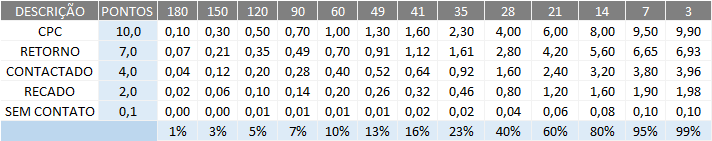

**PESO DA DATA DE ACIONAMENTO**

Quanto maior o tempo em que um acionamento ocorreu, em dias, menor o seu peso na pontuação de localização.

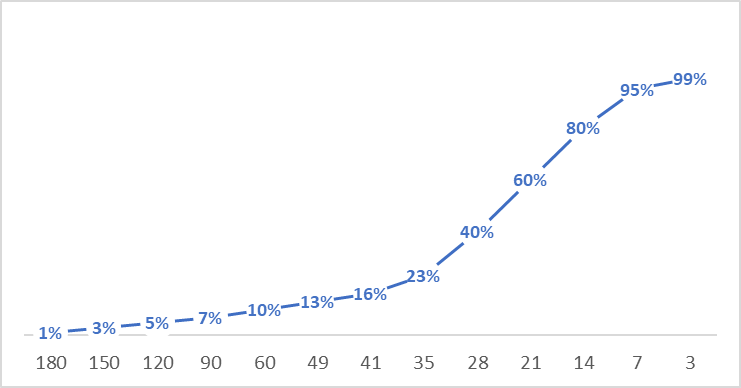


In [ ]:
#agrupando dados
#modo simplificado: df_groupby = df_final.groupby(["Contrato", "Alçada", "FAIXA", "CPFCNPJ"])["ptsloc"].sum()

df_groupby = df_final.groupby(["Contrato", "CPFCNPJ", "Carteira"]).agg({'ptsloc':'sum', 'PROMESSA Old': 'max', 'PROMESSA New': 'max', 
                                                                               'CPC Old': 'max', 'CPC New': 'max', 'Data': 'max'})

In [ ]:
#limitando em 2 casas decimais o campo 'ptsloc'
decimals = 2
df_groupby['ptsloc'] = df_groupby['ptsloc'].apply(lambda x: round(x, decimals))

In [ ]:
#adicionando o resultado ordenado em um df resultado
df_resultado = df_groupby.sort_values(by = ['ptsloc'],ascending=False)

#transformando as colunas index em colunas normais
#df_resultado = df_resultado.reset_index(level=[0,1,2,3,4])
df_resultado = df_resultado.reset_index(level=[0,1,2])

In [ ]:
#join dos dataframes para colocar último histórico
df_final_hist = pd.merge(df_resultado, df_ultimo_hist, how="left", on=["CPFCNPJ"])

In [ ]:
#transformar 'Alçada' em string e substituir vírgula por ponto
#df_final_hist['Alçada'] = df_comp['Alçada'].str.replace(',', '.')

In [ ]:
#criando a variável dia para incluir no nome do arquivo
today = datetime.today()
date = today.strftime('%Y%m%d')

In [ ]:
#criando um arquivo txt com o resultado final
df_final_hist.to_csv('/content/gdrive/Shareddrives/Bradesco/Estudos/ProbabilidadeLoc/probloc/probloc' + date + '.txt', 
                     sep='|', encoding='latin-1', index = False)

In [ ]:
#criando um arquivo csv com o resultado final
df_final_hist.to_csv('/content/gdrive/Shareddrives/Bradesco/Estudos/ProbabilidadeLoc/probloc/probloc' + date + '.csv', 
                     sep='|', encoding='latin-1', index = False)